# Pre-lab description
In this pre-lab we will learn how to implement gradient descent for finding local minima of a given cost function. This will provide us with a basic tool for many learning and classification problems since, at the end of the day, finding a classifier amounts to solving some optimization problem. In this lab we will also learn how gradient descent
can be implemented using [PyTorch](https://pytorch.org/tutorials/), a scientific library for developing machine (deep) learning methods. Towards that goal, we will be learning a [linear classifier](https://en.wikipedia.org/wiki/Linear_classifier) on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) digit [dataset](http://yann.lecun.com/exdb/mnist/). As a loss function, we will be using a simple quadratic function. You will first apply your calculus skills to the problem, and analytically solve it. Then you will learn how to solve the same problem by implementing the gradient descent method and applying it to the cost function. Finally, you will learn the basics of PyTorch by using the built-in functions to train the classifier. This pre-lab assignment needs to be solved in this Notebook.

## The data
The MNIST database \[[1](http://yann.lecun.com/exdb/mnist/)\]\[[2](https://en.wikipedia.org/wiki/MNIST_database)\] consists of $28\times 28$ grayscale images of handwritten digits, along with the correct label for each image. These are in the form of $28\times 28$ matrices with the value of each index being an 8-bit integer ranging from 0 (black) to 255 (white), and one integer between 0 and 9, corresponding to the digit displayed in the image. The database is split into two separate training and testing sets.


## Problem description
We are given a set of $N$ feature-label pairs $\big\{\big(\boldsymbol x_i,c_i\big)\big\}_{i=0}^{N-1}$ where each $\boldsymbol x_i\in\mathbb{R}^p$ corresponds to a vectorized $28\times28$ grayscale image of a digit, and $c_i=\{0,1,\ldots,9\}$ is the digit's class. Since we are dealing with a multi-class classification problem we will encode each digit's class with a one-hot embedding vector as:
$$\boldsymbol y_i = [y_{i0},\ldots, y_{in}],\quad y_{ij} = \begin{cases}1 &c_i = j\\0&\textrm{else}\end{cases}.$$
The goal is then to find a prediction function $f:\mathbb{R}^p\mapsto\{0,1\}^n$ that maps features $\boldsymbol x_i$ (images) to labels $\boldsymbol y_i$. In order to do so, we will use a linear prediction function:

$$f(\boldsymbol x) = \boldsymbol W \boldsymbol x,\quad \boldsymbol W\in\mathbb{R}^{p\times n},$$
where the $j$th row of $\boldsymbol W$ represents a predictor for the $j$th class. In order to decide upon the estimated class we take the strongest response of our set of predictors, that is:
$$\widehat{c}_i = \arg\max_{j}\,\boldsymbol W\boldsymbol x_i.$$

## Problem formulation (optimization problem)
With all previous considerations in mind we can now define the optimization problem to estimate the parameters $\boldsymbol W$ of our linear predictor. In order to do that, we need to define some loss function on our predictions that penalizes deviations from the true target. For this problem, we will be using a simple quadratic loss function $L\big(f(\boldsymbol x),\boldsymbol y\big) = \lVert \boldsymbol y - f(\boldsymbol x)\rVert_2^2$. The goal is then to find the parameters $\boldsymbol W$ of our linear predictor function $f(\cdot)$ that minimize the average loss over the set of samples:
$$\min_{\boldsymbol W}\; \frac{1}{N}\sum_{i=0}^{N-1}\lVert \boldsymbol y_i - \boldsymbol W\boldsymbol x_i\rVert_2^2.$$
Note that the above optimization problem can be expressed in a compact form as:
$$\min_{\boldsymbol W}\; \frac{1}{N}\lVert \boldsymbol Y - \boldsymbol W\boldsymbol X\rVert_F^2,$$
where $\lVert\cdot\rVert_F$ is the Frobenius ($\ell_2$) norm of a matrix, and where the matrices $\boldsymbol Y=[\boldsymbol y_0,\ldots,\boldsymbol y_{N-1}]$ and $\boldsymbol X = [\boldsymbol x_0,\ldots,\boldsymbol x_{N-1}]$ consist of stacking the label and feature vector representations, respectively.

**Exercise 1.** Given the feature and label matrices $\boldsymbol X\in\mathbb{R}^{p\times N}$ and $\boldsymbol Y\in\mathbb{R}^{n\times N}$, find a closed-form solution $\boldsymbol W^\star$ for the optimization problem:
$$\min_{\boldsymbol W}\; \frac{1}{N}\lVert \boldsymbol Y - \boldsymbol W\boldsymbol X\rVert_F^2.$$

Start by taking the derivative of the cost function and setting it equal to 0:

$$
\begin{align}
\frac{\partial}{\partial W} \frac{1}{N} \lVert Y - WX \rVert_F^2
&= \frac{\partial}{\partial W} \frac{1}{N} \text{Tr} \left( (Y - WX)^\top(Y - WX) \right) \\
&= \frac{\partial}{\partial W} \frac{1}{N} \text{Tr} \left( Y^{\top}Y - Y^{\top}WX - X^{\top}W^{\top}Y + X^{\top}W^{\top}WX \right) \\
&= \frac{1}{N} \left( 0 - YX^\top - YX^\top + W(XX^\top) \right) \\
&= \frac{2}{N} \left( W(XX^\top) - YX^\top \right) \\
&= 0 \,.
\end{align}
$$

Next, solve for $W$:

$$
\begin{align}
W(XX^\top) &= YX^\top \\
W^\star &= YX^\top(XX^\top)^{-1} = YX^+ \,.
\end{align}
$$

# Data loading and pre-processing

First we need to download the data to Google Drive and pre-process it. The MNIST database is very well known and available to download in PyTorch using a [pre-defined function](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist). Then, we scale and shift the images such that the value associated with each index lies between -1 and +1. Again, we can use pre-defined PyTorch [transform functions](https://pytorch.org/docs/stable/torchvision/transforms.html) to do so. This requires an extra step of casting the image to a `torch.Tensor` object. Tensors are multi-dimensional array objects that PyTorch uses as variables.

As usual, we start our Python code by importing the dependencies, and mounting Google Drive:

In [1]:
# import modules here
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl
from sklearn.preprocessing import OneHotEncoder
import torch
import torchvision
import torchvision.transforms as transforms

# inline plots for matplotlib
%matplotlib inline

# mount GDrive
# from google.colab import drive
# drive.mount('gdrive/')

Next, we use the `torchvision.datasets.MNIST` command to load the database. For this purpose, make a folder named `prelab-02` inside a `bmdslab` directory in your Google Drive. As the database is very large and contains more images than we require, we use the PyTorch [dataloader function](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to load a certain number of images, along with their labels, as local varables: 

In [2]:
# set the seed of PyTorch random number generator for reproducibility
torch.manual_seed(0)

# define transformation object to be applied to the data, list of transformations through Compose
# first convert to tensor
# then subtract 0.5 to every entry
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# download the data if not already in the specified directory
trainset = torchvision.datasets.MNIST('gdrive/My Drive/bmdslab/prelab-02/', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST('gdrive/My Drive/bmdslab/prelab-02/', train=False, transform=transform, download=True)

# specify the number of points to be extracted at every iteration
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10000,shuffle=False) # 10,000 images from the training set
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,shuffle=False)    #  1,000 images from the testing set

# create an iterator to return the data from the data loader
dataiter = iter(trainloader)
# loading the training data into the images and labels variables
images, labels = dataiter.next()

# similarly for the test data
test_dataiter = iter(testloader)
test_images, test_labels = test_dataiter.next()

In [3]:
# check the sizes to make sure you have done everything right:
print(images.shape) # you should get [10000,1,28,28]
print(labels.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


Now your data is in the `images` variable. Let's just display an example.

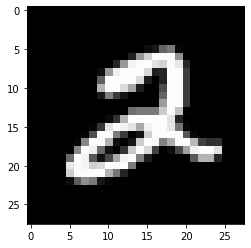

tensor(0.9843)


In [4]:
# choose an index
num_image = 5

# for displaying an image we need to convert the tensor to a numpy array
# the squeeze() function removes all redundant dimensions of the array i.e.,
# images[num_array] is a 1x1x28x28 array
plt.imshow(images[num_image].numpy().squeeze(), cmap='gray')
plt.show()

# maybe investigate the values:
print(images[1, 0, 22, 10].squeeze())

**Exercise 2.** Using the data provided for training and the expression for the optimal predictor's weights derived in the previous exercise compute the optimal predictor over the training data. Apply also your predictor to the training set. Report classification accuracy over both training and testing sets. Display the obtained weights as images. Do you observe any correlation between the predictors and the digits? Why?

For a set of ground-truth labels $c_i$ and their corresponding estimates $\widehat{c}_i$, the __accuracy__ is defined as:

$$Acc = \frac{1}{N}\sum_{i=0}^{N-1}\mathbb{1}\big(c_i == \widehat{c}_i\big),\quad \mathbb{1}\big(z\big) = \begin{cases}1&z\; \textrm{is true}\\0 &\textrm{else}\end{cases}.$$

In [5]:
class LinearPredictor:

    def __init__(self, images, labels):

        # Preprocess the images and labels
        images, labels = self._preprocess_training_data(images, labels)

        # Assign preprocessed training set as class attributes
        self.x = images
        self.y = labels

    def _preprocess_training_data(self, images, labels):
        """
        Convert all training data to numpy arrays with proper dimensions.
        """

        # Process the images
        images = images.numpy().squeeze().reshape(10000, -1).T

        # Encode the labels
        enc = OneHotEncoder()
        enc.fit(labels.reshape(-1, 1))
        labels = enc.transform(labels.reshape(-1, 1)).toarray().T

        return images, labels
    
    def _predict(self, test_images):
        """
        Predict the class labels for a given set of images.
        """
        test_images = test_images.numpy().squeeze().reshape(-1, 784).T
        predictions = np.dot(self.w, test_images)
        return np.argmax(predictions, axis=0)
    
    def fit(self):
        """
        Solve for W*.
        """
        self.w = npl.multi_dot(
            [self.y, self.x.T, npl.pinv(np.dot(self.x, self.x.T))]
        )

    def accuracy(self, test_images, test_labels):
        """
        Determine accuracy across the testing set. 
        """
        yhat = self._predict(test_images)
        y = test_labels.numpy()
        return np.mean(yhat == y)

In [6]:
# Fit the linear predictor
linear_predictor = LinearPredictor(images, labels)
linear_predictor.fit()

In [7]:
# Determine the accuracy
acc = linear_predictor.accuracy(test_images, test_labels)
print("Testing accuracy: {}".format(acc))

Testing accuracy: 0.804


## Optimization via gradient descent
The quadratic optimization problem considered in this pre-lab has a closed-form solution. In many practical cases however, a closed-form solution does not exist and the solution needs to be computed via an iterative method. Suppose we are given a smooth cost function $C(\boldsymbol x)$ that we want to minimize over $\boldsymbol x$. A very simple method to find a local minimizer of the function is to use a _gradient descent_ method. The main idea is to compute the gradient (derivative) of the cost function at a given point and move towards the direction opposite to the gradient of the function (recall that the gradient of a function gives you the direction of maximum variation of the signal). This process is repeated until convergence to a critical point of the cost function to be minimized. The general procedure for the gradient descent method at every iteration is given by the following update rule:
$$
 	\boldsymbol x^{(k+1)} = \boldsymbol x^{(k)} - \mu \nabla_{\boldsymbol x} C\big(\boldsymbol x^{(k)}\big),
$$
where $\boldsymbol x^{(k)}$ denotes the estimate at $k$th iteration, $ \nabla_{\boldsymbol x} C\big(\cdot\big)$ is the gradient of $C\big(\cdot\big)$ with respect to $\boldsymbol x$, and $\mu$ is the step-size for the gradient descent updates.

**Exercise 3.** _(Optional)_ Write down the equation for the gradient descent of the considered problem. Starting from an initial weight matrix of all zeros $\boldsymbol W^{(0)}=\boldsymbol 0$ implement a gradient descent optimization algorithm to find the optimal solution to our classification problem. Run the method for a sufficiently large number of iterations or until you meet some convergence criterion (_e.g.,_ relative change of the cost function smaller than some threshold). On two separate plots, display the evolution of the cost function over the iterations and the difference between your current estimate and the optimal estimate $\lVert \boldsymbol W^\star - \boldsymbol W^{(k)} \rVert_F^2$. Since the considered cost function has a unique and global minimizer your iterates should converge to the optimal solution obtained from the analytical expression.

*Write the expression for the gradient update in this cell*

$$
\begin{align}
W^{(k+1)} &= W^{(k)} - \mu \nabla_{W} \lVert Y - W^{(k)}X \rVert_F^2 \\
&= \left( W(XX^\top) - YX^\top \right)
$$ 

**Exercise 4.** Repeat the exercise before but now using PyTorch taking advantage of its automatic differentiation feature that will compute the gradients for you. Go to the [PyTorch tutorials](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) page in order to learn how to manipulate tensors with autograd. You can use random initialization for the weights $\boldsymbol W^{(0)}$. Why initialization does not matter in this problem?